In [1]:
from pyheatmy import *
from typing import List, Sequence, Union
from numbers import Number
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
PARAM_LIST = ("moinslog10IntrinK", "n", "lambda_s", "rhos_cs")

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

In [5]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

In [6]:
Layer_1 = {
    "name": "Layer 1",
    "zLow": 0.2,
    "Prior_moinslog10IntrinK": Prior((9, 15), .01), # (intervalle, sigma)
    "Prior_n": Prior((.001, .25), .005),
    "Prior_lambda_s": Prior((1, 10), .1),
    "Prior_rhos_cs": Prior((1e6,1e7), 1e5),
    "Prior_q": Prior((1e-6,1e-5), 1e-6)
}

Layer_2 = {
    "name": "Layer 2",
    "zLow": 0.3,
    "Prior_moinslog10IntrinK": Prior((4, 9), .01), # (intervalle, sigma)
    "Prior_n": Prior((.001, .25), .005),
    "Prior_lambda_s": Prior((1, 10), .1),
    "Prior_rhos_cs": Prior((1e6,1e7), 1e5),
    "Prior_q": Prior((1e-6,1e-5), 1e-6)
}

Layer_3 = {
    "name": "Layer 3",
    "zLow": 0.4,
    "Prior_moinslog10IntrinK": Prior((4, 9), .01), # (intervalle, sigma)
    "Prior_n": Prior((.001, .25), .005),
    "Prior_lambda_s": Prior((1, 10), .1),
    "Prior_rhos_cs": Prior((1e6,1e7), 1e5),
    "Prior_q": Prior((1e-6,1e-5), 1e-6)
}

In [7]:

col.set_layers([Layer.from_dict(Layer_1), Layer.from_dict(Layer_2), Layer.from_dict(Layer_3)])

In [8]:
col.compute_mcmc()

C:\Users\Martin\Desktop\Mines\Molonari\MOLONARI1D\pyheatmy\pyheatmy\linear_system.py:40: RuntimeWarning: overflow encountered in square
  mu = MU_A * np.exp(MU_B * 1.0 / T + MU_C * T + MU_D * (T**2))


Initialisation - Utilisation de la mémoire (en Mo) : 277.495808


Burn in phase:   0%|          | 0/150 [00:00<?, ?it/s]C:\Users\Martin\Desktop\Mines\Molonari\MOLONARI1D\pyheatmy\pyheatmy\linear_system.py:40: RuntimeWarning: overflow encountered in exp
  mu = MU_A * np.exp(MU_B * 1.0 / T + MU_C * T + MU_D * (T**2))
Burn in phase: 100%|██████████| 150/150 [02:41<00:00,  1.08s/it]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 280.154112
DREAM MCMC Computation:  24%|██▍       | 36/150 [00:38<02:02,  1.07s/it]

C:\Users\Martin\Desktop\Mines\Molonari\MOLONARI1D\pyheatmy\pyheatmy\linear_system.py:40: RuntimeWarning: invalid value encountered in add
  mu = MU_A * np.exp(MU_B * 1.0 / T + MU_C * T + MU_D * (T**2))


DREAM MCMC Computation: 100%|██████████| 150/150 [02:41<00:00,  1.07s/it]
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 437.301248


In [9]:
col.get_best_layers()

RMSE at sensor 0 : 0.13700216325168724
RMSE at sensor 1 : 0.20254154795629073
RMSE at sensor 2 : 0.14175621686197235
Total RMSE : 0.1631844522855358


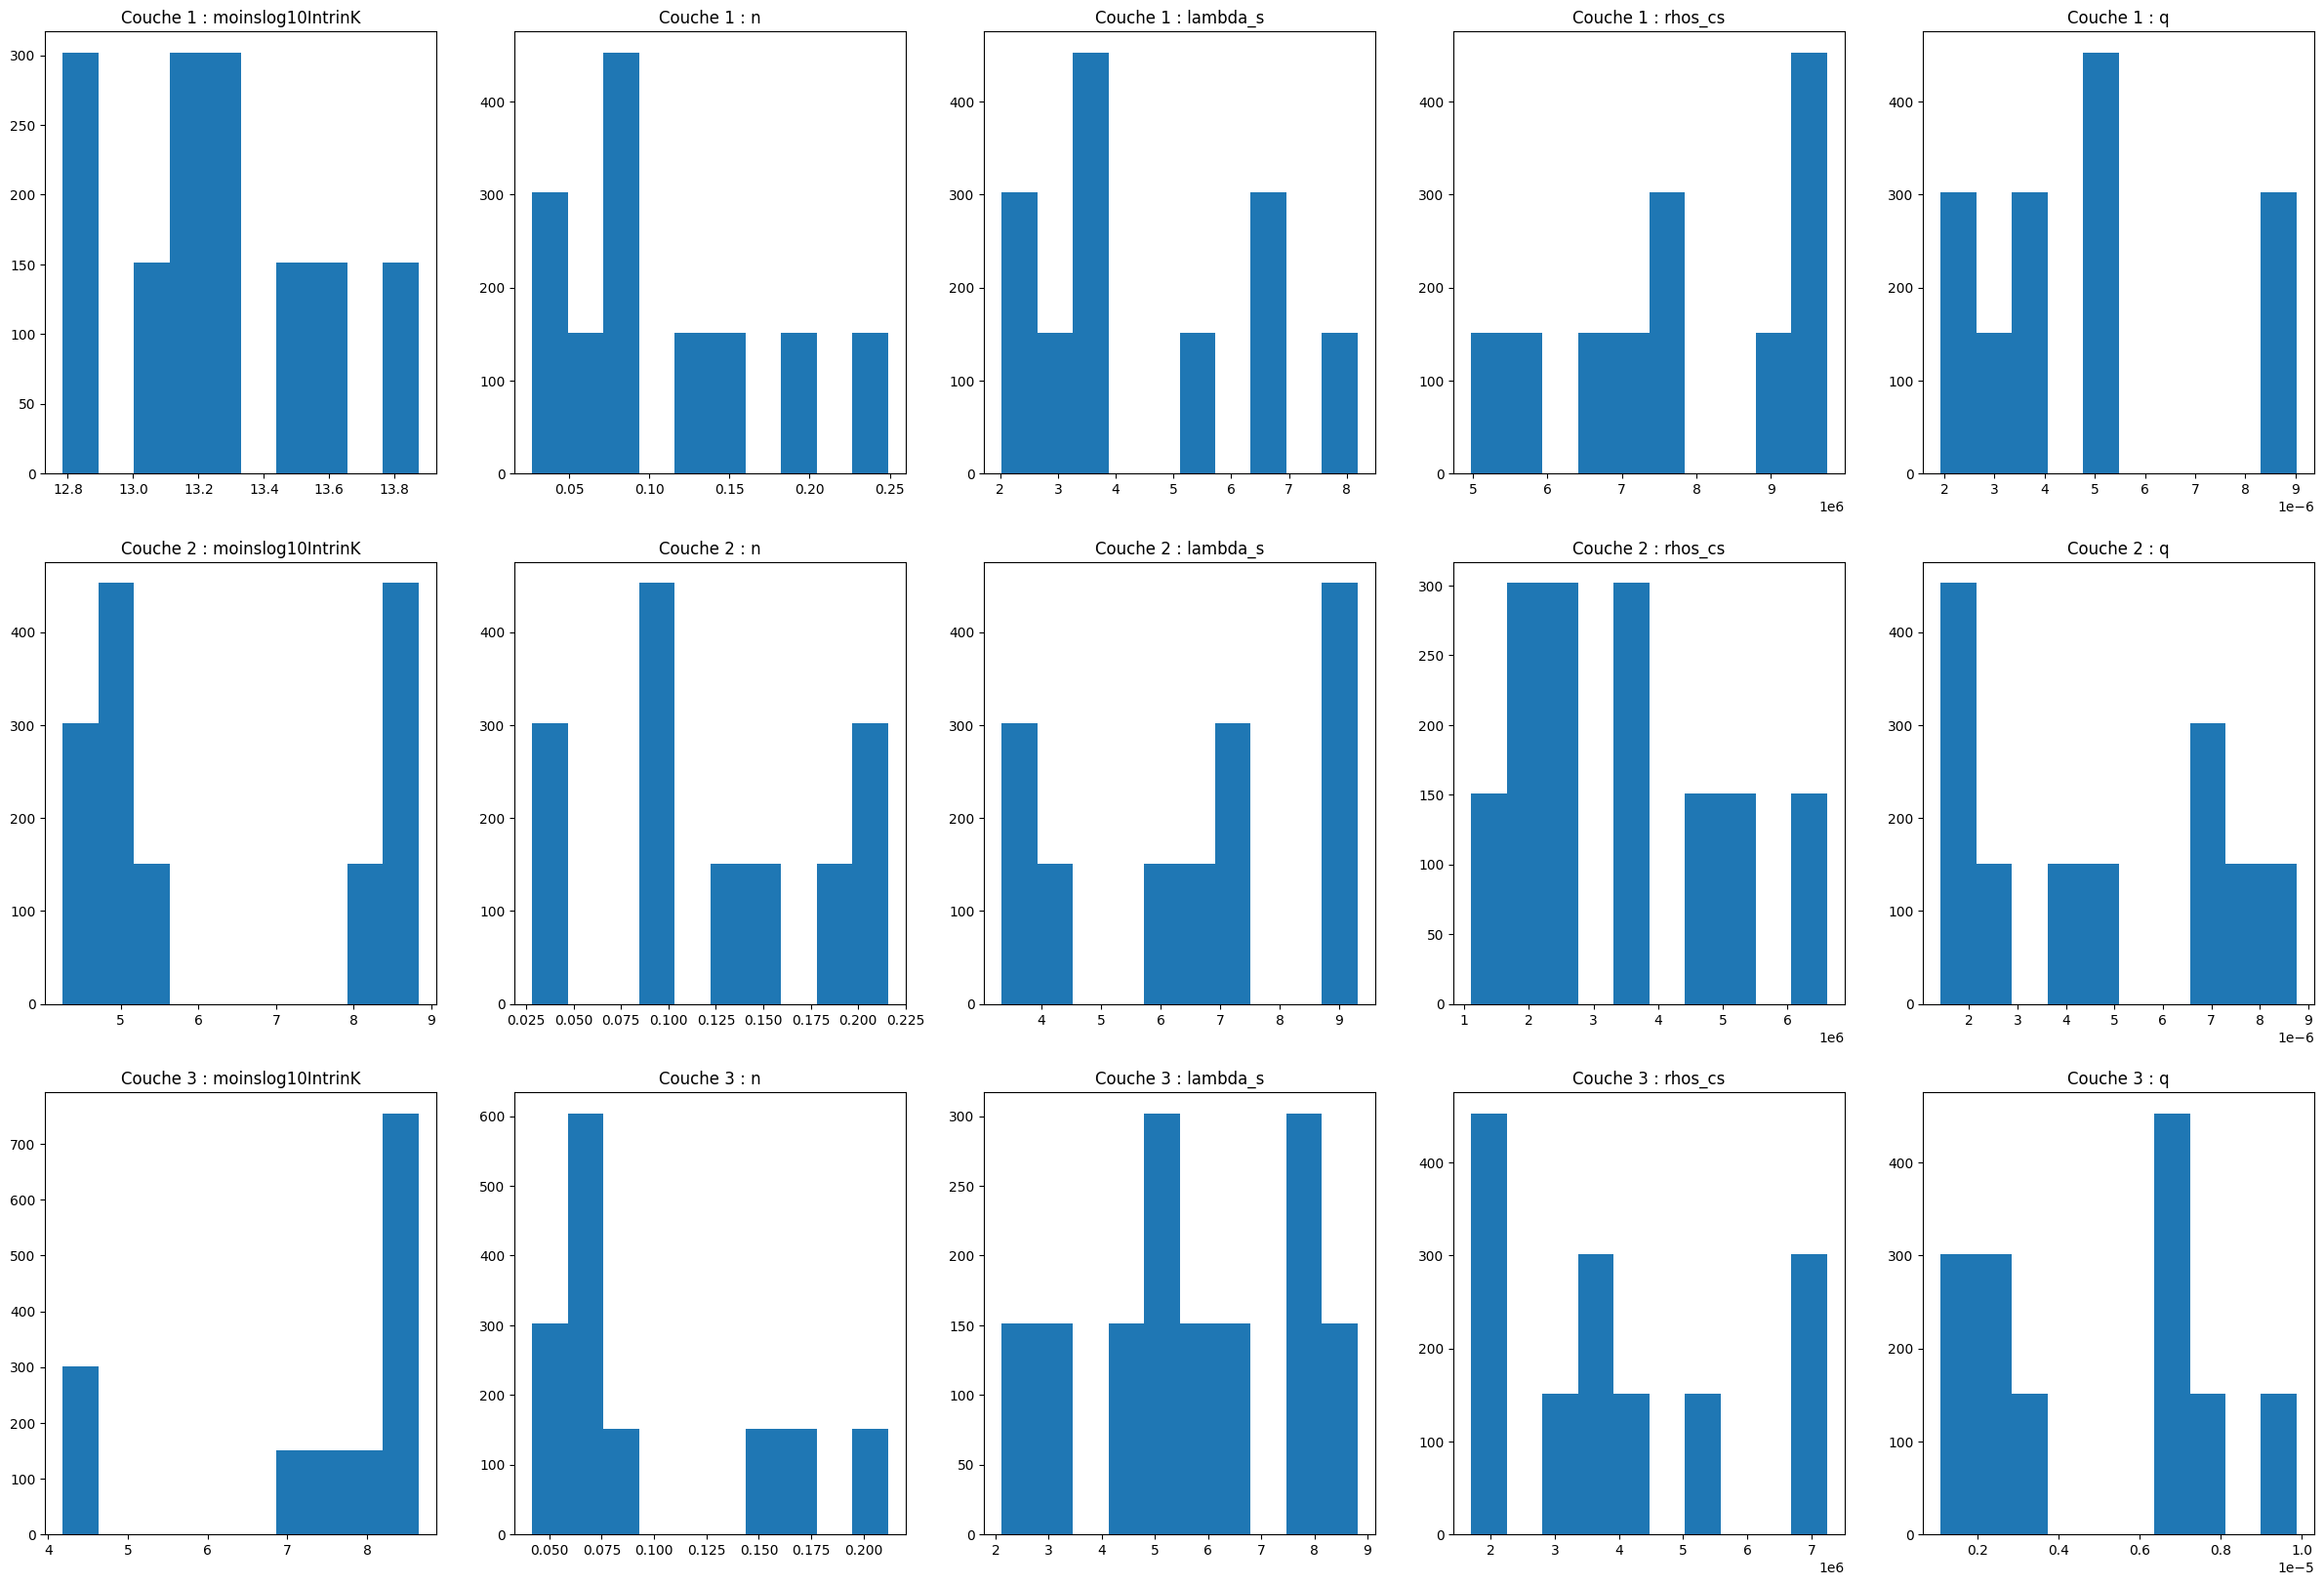

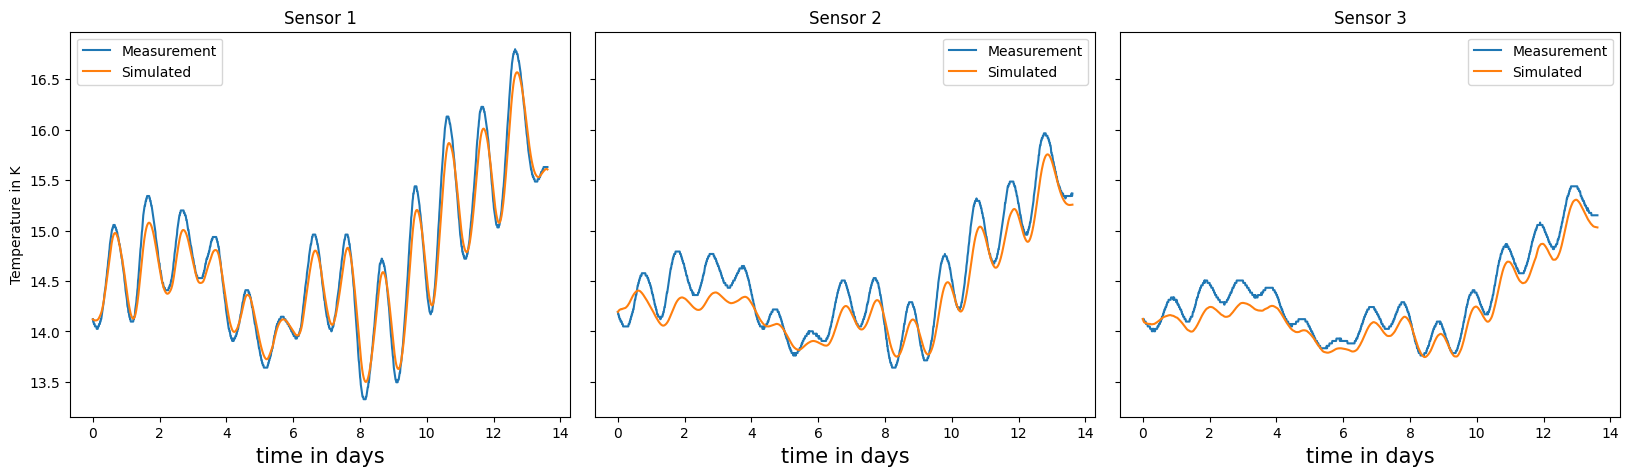

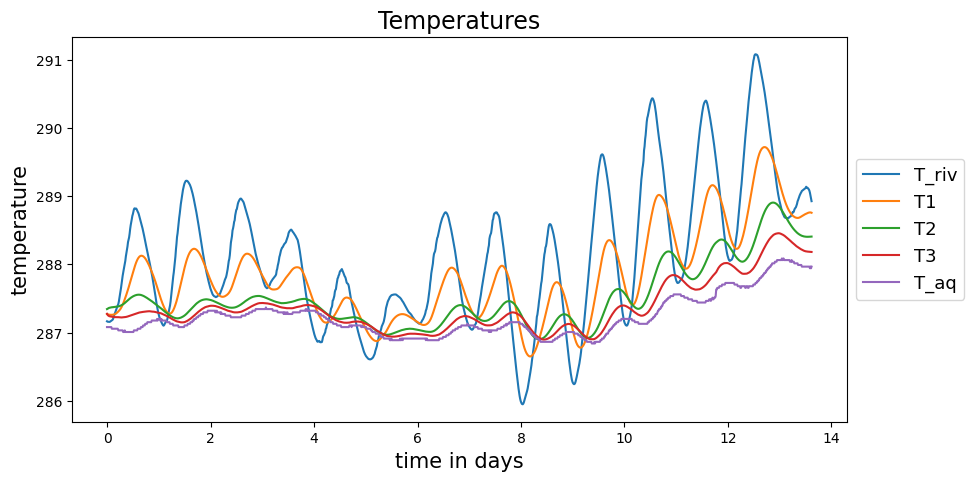

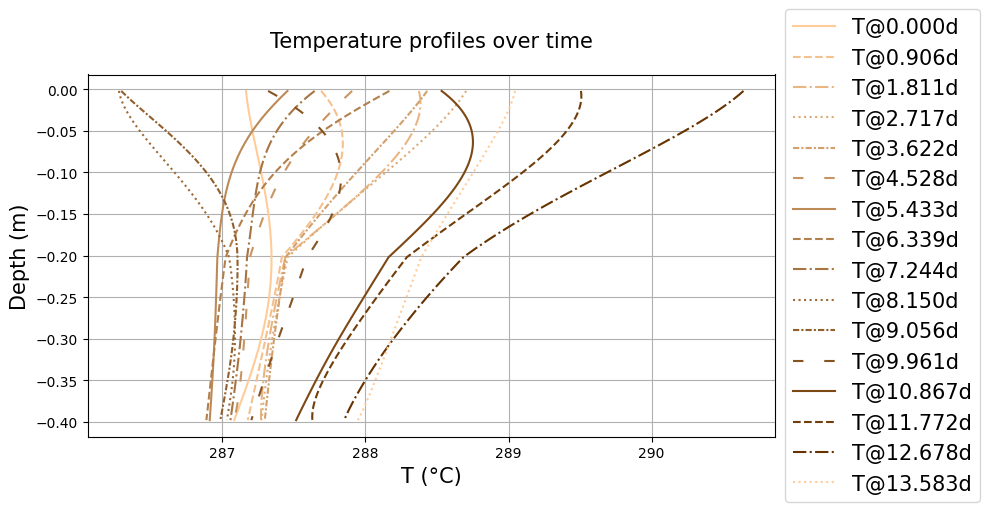

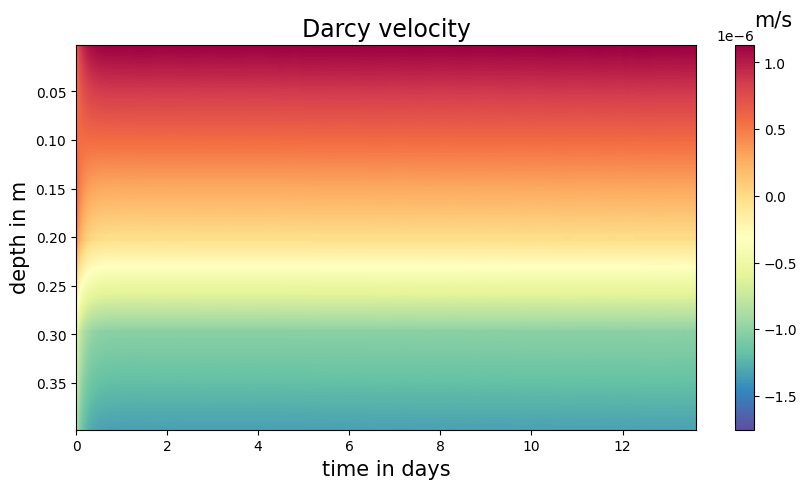

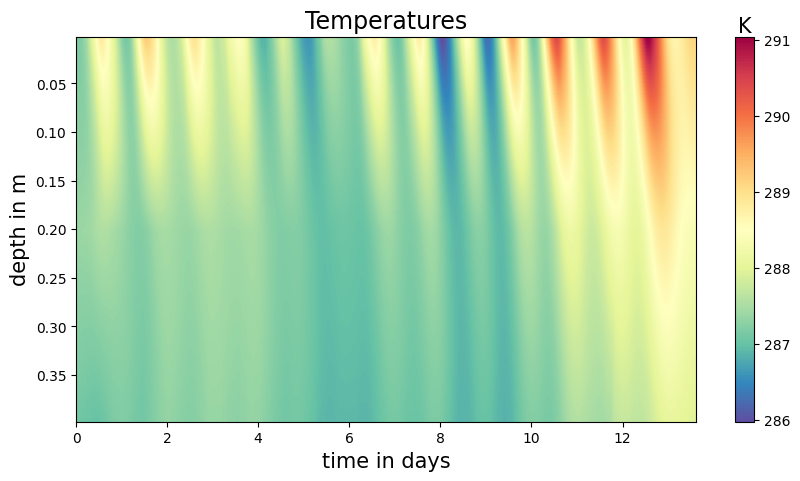

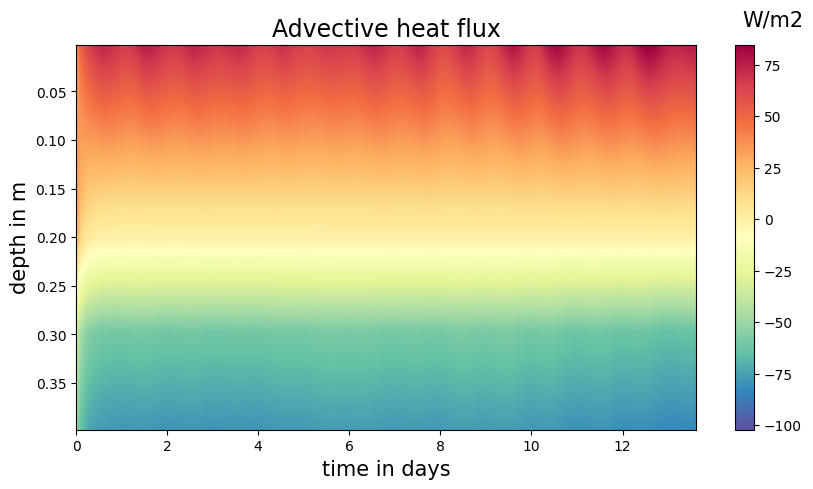

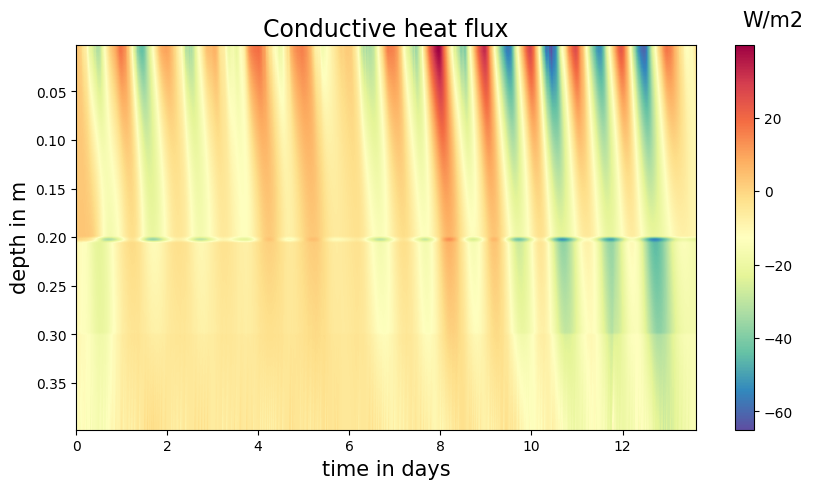

Plotting Température in column. time series have nrecords =  1309


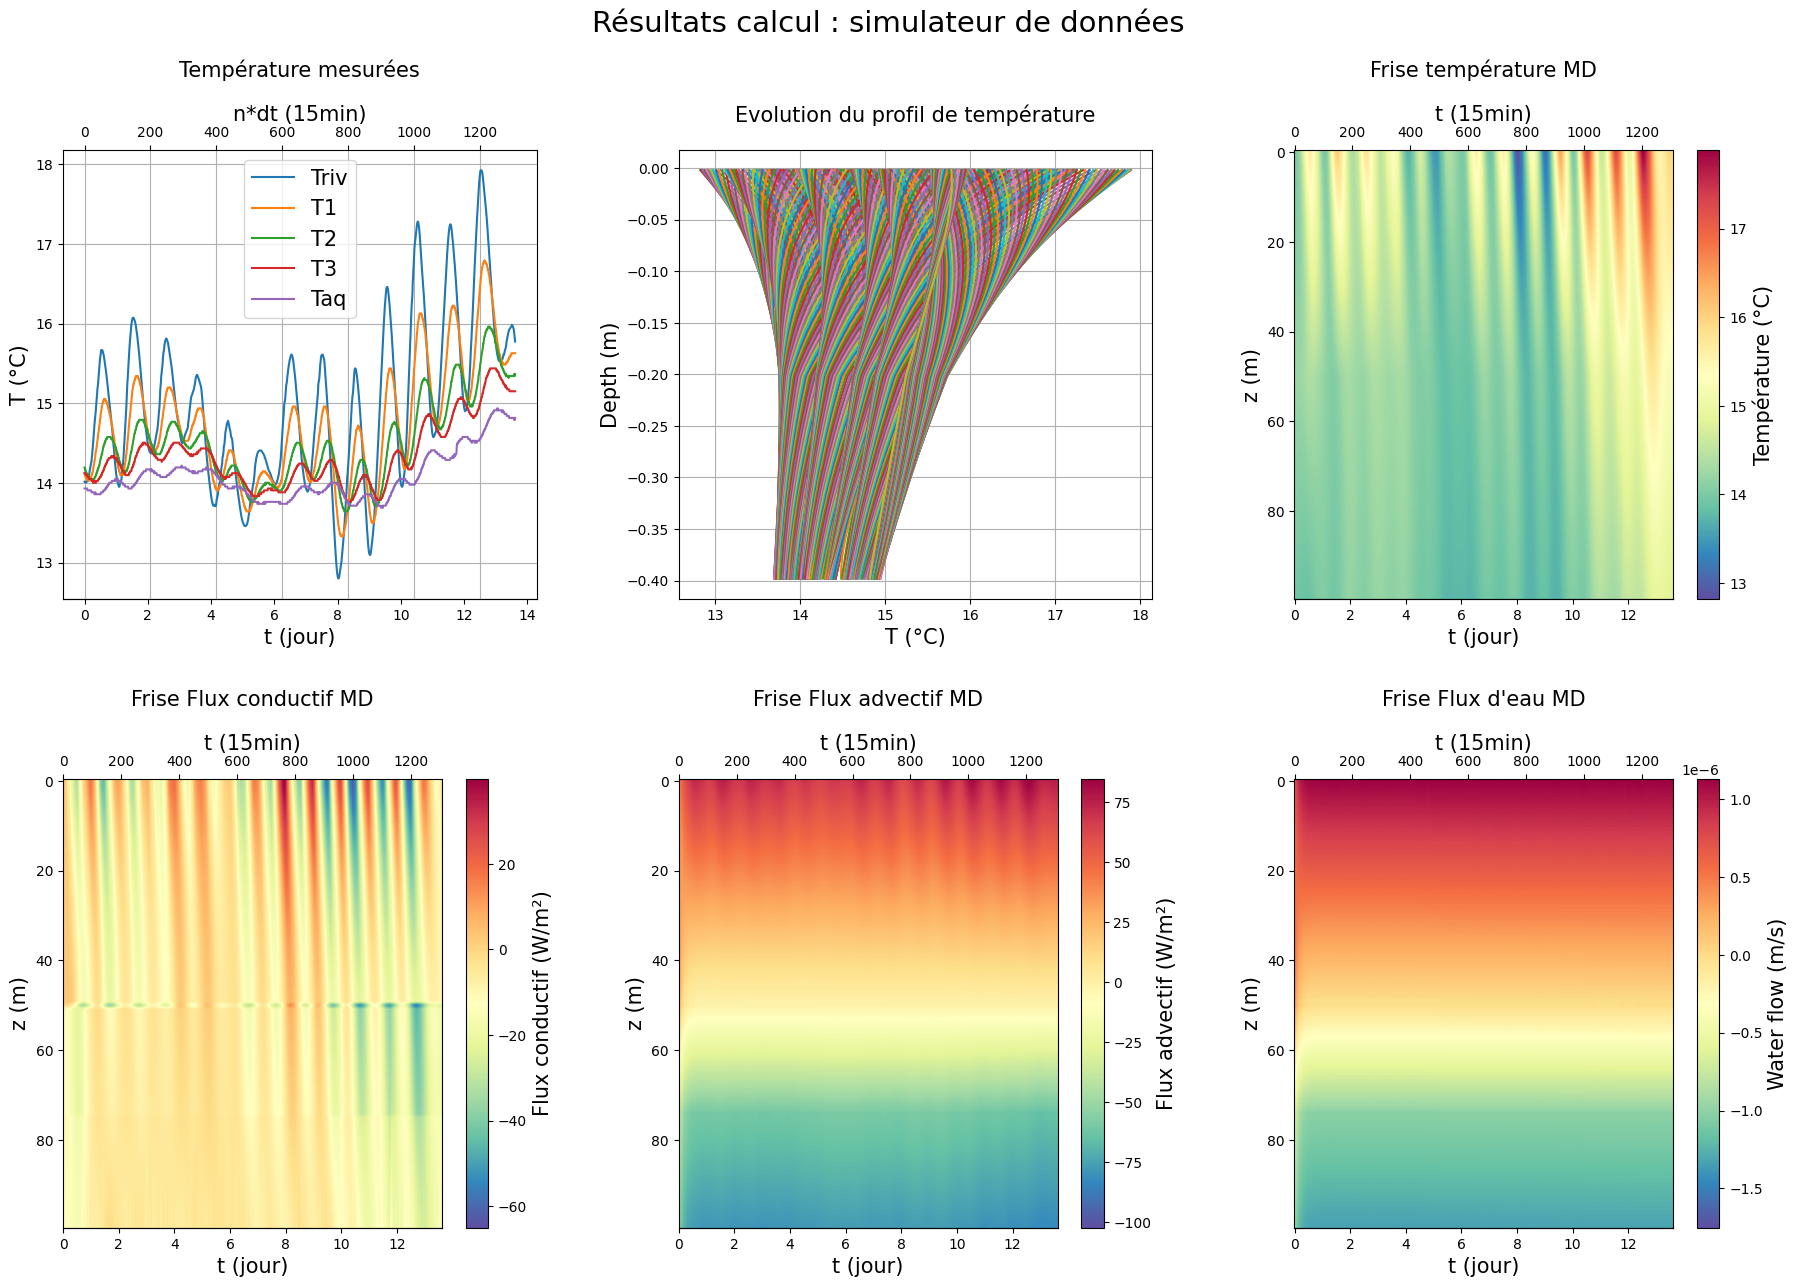

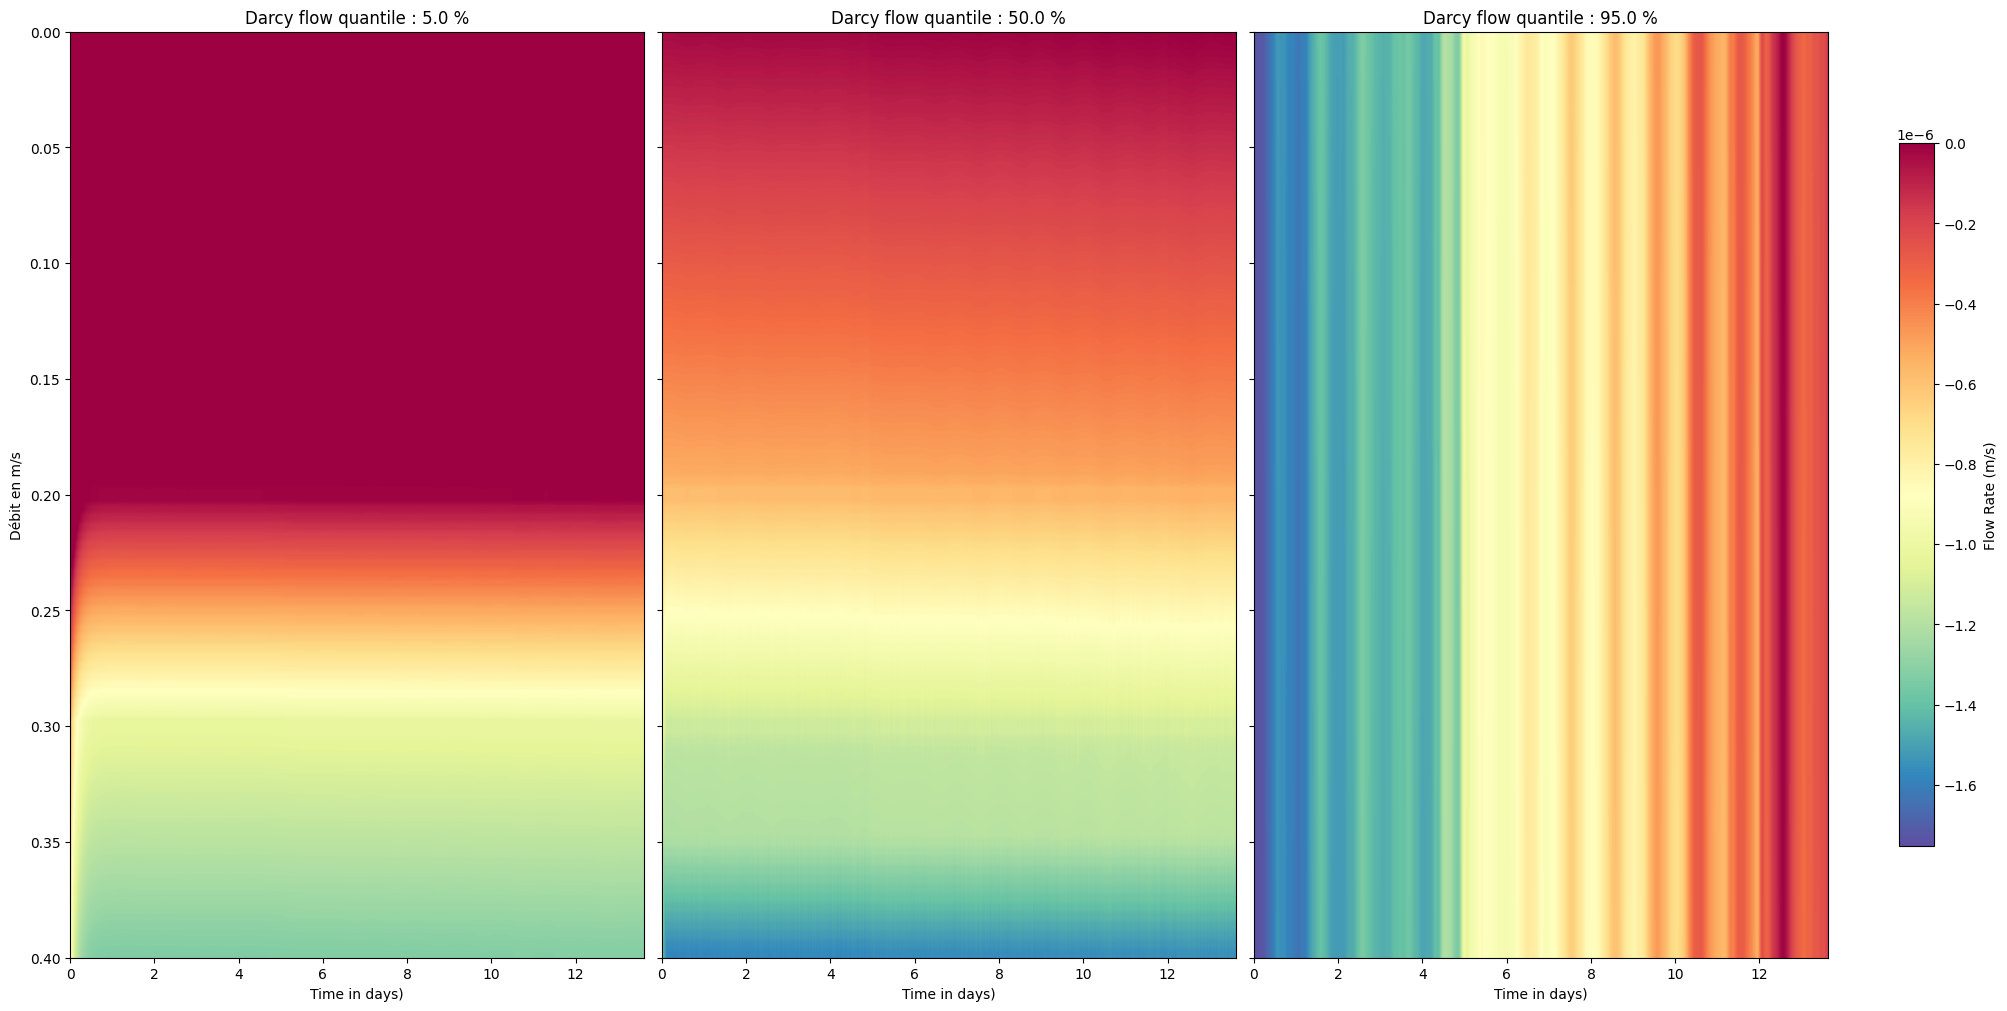

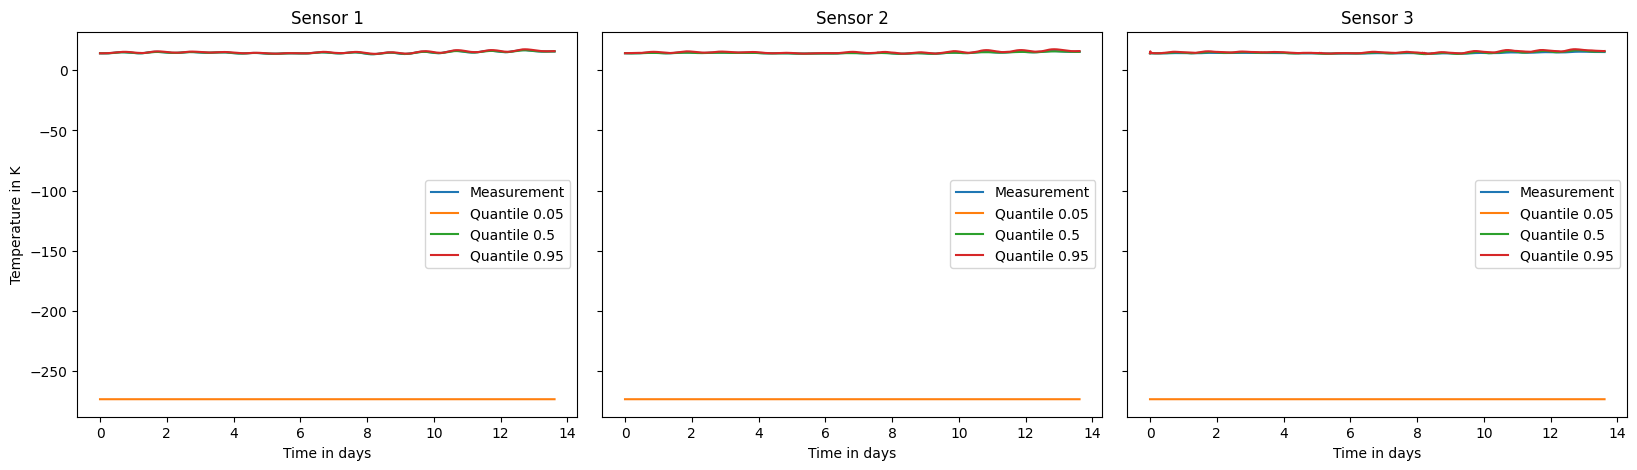

In [10]:
col.compute_solve_transi(verbose=False)
col.plot_all_param_pdf()
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

# Calcul des quantiles

Voilà la façon dont sont calculés les quantiles de température (idem pour le flow) dans le projet.

In [11]:
"""quantile = np.array([0.05, 0.5, 0.95])
quantiles_temperatures = np.quantile(_temp, quantile, axis=0)"""

'quantile = np.array([0.05, 0.5, 0.95])\nquantiles_temperatures = np.quantile(_temp, quantile, axis=0)'

Le calcul est gourmand en temps de calcul et nécessite de stocker un tableau `quantiles_temps` et un tableau `temp` dont les tailles sont indiquées ci-dessous.

In [12]:
"""print("Dimensions de quantiles_temperatures : ", quantiles_temperatures.shape, " (nb_quantiles, nb_chain, n_cells, n_temperatures)")
print("Dimensions de quantiles_temperatures : ", _temp.shape, " (nb_iter, nb_chain, n_cells, n_temperatures)")"""

'print("Dimensions de quantiles_temperatures : ", quantiles_temperatures.shape, " (nb_quantiles, nb_chain, n_cells, n_temperatures)")\nprint("Dimensions de quantiles_temperatures : ", _temp.shape, " (nb_iter, nb_chain, n_cells, n_temperatures)")'

Ces deux tableaux représentent un encombrement mémoire important qui dépasse le seuil fixé par le cahier des charges.

In [13]:
"""print("Mémoire pour les quantiles de température : ", quantiles_temperatures.nbytes/1000000, " Méga octets.")
print("Mémoire pour les températures : ", _temp.nbytes/1000000000, "Giga octets.")"""

'print("Mémoire pour les quantiles de température : ", quantiles_temperatures.nbytes/1000000, " Méga octets.")\nprint("Mémoire pour les températures : ", _temp.nbytes/1000000000, "Giga octets.")'

Pour réduire cet encombrement mémoire, on peut intuitivement supposer que les profils de température ne varient pas énormément entre deux pas de temps consécutifs. On peut donc réaliser un sous-échantillonnage sur les pas de temps afin de calculer les quantiles. De même, on peut réaliser un sous-échantillonnage spatial.

In [14]:
"""n_sous_ech_time = 2 # 1 mesure considérée par demi-heure
n_sous_ech_space = 4 # 1 mesure considérée tous les 2 cm

_temp_sous_ech = _temp[:,:,::n_sous_ech_space,::n_sous_ech_time]
quantiles_temperatures_sous_ech = np.quantile(_temp_sous_ech, quantile, axis=0)

np.allclose(quantiles_temperatures_sous_ech,  quantiles_temperatures[:, :, ::n_sous_ech_space, ::n_sous_ech_time])"""

'n_sous_ech_time = 2 # 1 mesure considérée par demi-heure\nn_sous_ech_space = 4 # 1 mesure considérée tous les 2 cm\n\n_temp_sous_ech = _temp[:,:,::n_sous_ech_space,::n_sous_ech_time]\nquantiles_temperatures_sous_ech = np.quantile(_temp_sous_ech, quantile, axis=0)\n\nnp.allclose(quantiles_temperatures_sous_ech,  quantiles_temperatures[:, :, ::n_sous_ech_space, ::n_sous_ech_time])'

Les quantiles sont calculés sur chaque case $(chaine, cellule, temps)$ en utilisant les valeurs obtenues avec les itérations, il est donc normal que ces deux calculs conduisent aux mêmes valeurs de quantiles.

Déterminons alors le nouvel encombrement mémoire :

In [15]:
#print("Mémoire pour les quantiles de température : ", quantiles_temperatures_sous_ech.nbytes/1000000, " Méga octets.")
#print("Mémoire pour les températures : ", _temp_sous_ech.nbytes/1000000000, "Giga octets.")

## Utilisation de la méthode P2

Tout d'abord, réalisons le calcul des quantiles avec l'algorithme P2 en stockant les données du tableau afin de vérifier si c'est plus rapide ou non que la fonction `np.quantile`.

In [16]:
"""def P2(p, data):
    """
#    Input : p [float] - nombre du quantile que l'on veut estimer (ex: médiane -> p=0.5)
#            data [2D float np.array] - jeu de données désordonné

#    Output : [float] estimation du p-ième quantile
    """

    # INITIALISATION

    markers = np.sort(data[:5])
    markers_index = np.arange(5)
    desired_index = np.array([1., 1+2*p, 1+4*p, 3+2*p, 5])
    increment = np.array([0, p/2, p, (1+p)/2, 1])

    # ITERATION

    for x in data[5:]:
        # x est l'observable suivante (actuellement avec le tableau data mais à améliorer pour ne rien avoir à stocker)

        # Déterminer l'indice k tel que marker[k] <= x < marker[k+1]
        k = np.searchsorted(markers, x, side='right') - 1

        if k == 0:
            # Ajuster le minimum
            markers[0] = x
        
        elif k == 4:
            # Ajuster le maximum
            markers[4] = x 

        # Incrémenter les positions des markers au-delà de x
        markers_index[k+1:] += 1

        # Incrémenter toutes les positions désirées
        desired_index += increment 

        # Ajuster les markers centraux si nécessaire
        for i in range(1,4):
            d = desired_index[i] - markers_index[i]

            if ( (d >= 1) and (markers_index[i+1] - markers_index[i] > 1) ) or ( (d <= -1) and (markers_index[i-1] - markers_index[i] < -1) ):

                d = int(np.sign(d))

                # P2 formula
                a = d / (markers_index[i+1] - markers_index[i-1])
                b = (markers_index[i] - markers_index[i-1] + d) * (markers[i+1] - markers[i]) / (markers_index[i+1] - markers_index[i])
                c = (markers_index[i+1] - markers_index[i] - d) * (markers[i] - markers[i-1]) / (markers_index[i] - markers_index[i-1])
                q = markers_index[i] + a * (b + c)

                # Ordonnement des markers
                if markers[i-1] <= q <= markers[i+1]:
                    markers[i] = q
                
                else:
                    # Linear formula
                    markers[i] += d * (markers[i+d] - markers[i]) / (markers_index[i+d] - markers_index[i])

                markers_index[i] += d 
        
    # RENVOYER L'APPEOXIMATION DU p-IEME QUANTILE

    return markers[2]"""


IndentationError: unexpected indent (4267257810.py, line 7)

In [ ]:
# quantiles_sous_ech_P2 = np.zeros(quantiles_temperatures.shape)
# nb_cells_sous_ech = nb_cells // n_sous_ech_space
# nb_times_sous_ech = _temp.shape[-1] // n_sous_ech_time

# for i,q in enumerate(quantile):
#     for j in range(nb_chain):
#         for c in range(nb_cells_sous_ech):
#             for t in range(nb_times_sous_ech):
#                 tab = _temp_sous_ech
#                 quantiles_sous_ech_P2[i,j,c,t] = P2(q, _temp_sous_ech[:,j,c,t])

C'est très lent, je déconseille d'attendre la fin de l'exécution. On rejette donc immédiatement l'éventualité de remplacer `np.quantile` par P2, bien que ce dernier algorithme ait l'avantage de fonctionner même sans stocker les données dans un tableau. Nous utiliserons uniquement le sous-échantillonnage dans la suite et essayerons deux protocoles dans le but de respecter la contrainte de 2Go de mémoire vive imposée par le cahier des charges.

## Les solutions envisagées

* Ecrire dans un fichier pendant la MCMC pour ne pas encombrer la mémoire de plus de 5Go de données
* Ne pas écrire dans un fichier mais retrouver les distributions de température uniquement avec les quantiles obtenus avec le tableau sous-échantillonné, calculé pendant MCMC.